# Notebook for sklearn related stuff

run on environment- correlate or umap

anything with sklearn (such as PCA and tsne

also 3d spatial correlation+PCA


Note that for this environment, install the pandas excel module after conda installing panda via pip install "pandas[excel]" for installing openpyxl module


good read for tsne:
- https://distill.pub/2016/misread-tsne/

- https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html

good read for pca:
https://builtin.com/machine-learning/pca-in-python

In [1]:
import os
import numpy as np

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

from scipy.ndimage import gaussian_filter

import pandas as pd
pd.options.mode.chained_assignment = None 
# disable the chained assignment warning

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator


In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df_old(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/','/512/']
    cc_cb_bs= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 and cerebellum  512 region only 
      
    new= cc_cb_bs.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def prep_df(df):
    ''' now only include regions belonging to and /343/ brainstem /567/ cerebrum  (but excluding /698/ olfactory areas and /1089/ hippocampal formation that belongs under /567/)'''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/']
    cc_cb= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 only
    
    search_exclude = ['/1089/', '/698/']
    cc_cb_clean= cc_cb.loc[~cc_cb['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
      
    new= cc_cb_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_old(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df

def combine_df(folder,list_of_fname):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_df=[]
    
    for i in (list_of_fname):
        new_df=prep_df(os.path.join(folder, i))
        full_df.append(new_df)

    full_df=pd.concat(full_df,axis=1)
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    
    search_exclude = ['/1089/', '/698/']
    specific_df_clean= specific_df.loc[~specific_df['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
    
    new= specific_df_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

def plot_lowD(array_2d, reduce_type=''):
    ''' plot scatter 2d representation of high dimensional data (ie. after pca, tsne, or umap)
    input 2d array with the two components and reduction method type (ie. 'pca', 'tsne', 'umap', etc..)
    
    '''
    
    df = pd.DataFrame()
    df["sample"] = final_column_order
    df["comp-1"] = array_2d[:,0]
    df["comp-2"] = array_2d[:,1]

    df['genotype_injection']=label_list_series
    # find and assign genotype and injection sit
    
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'{reduce_type}', fontsize = 20)

    for key, value in label_colors.items():
        indicesToKeep = df['genotype_injection'] == key

        if 's2' in key:
            marker= 'x'
        else:
            marker='o'

        ax.scatter(df.loc[indicesToKeep, 'comp-1']
                   ,df.loc[indicesToKeep, 'comp-2']
                   , c = value
                   , s = 50, 
                  marker=marker)

        ax.legend(label_colors.keys())
        ax.grid()
    
    return 

## categorical data (excel files -# axons in brain region) for all samples

In [3]:
# loading and preparing data

In [3]:
level_detail= 'parent'
# 'parent' or 'layers'

if level_detail== 'parent':
    # this will use parent level anatomical region
    L_keyword= 'Lparent'
    R_keyword= 'Rparent'
elif level_detail == 'layers':
    # this will use most detailed level anatomical regions including layers
    L_keyword= 'left_region'
    R_keyword= 'right_region'

In [4]:

indir= r'D:\viral_results\s1_result'

column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of september .2023

axons_L= [ i for i  in os.listdir(indir) if L_keyword in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axons_R= [ i for i  in os.listdir(indir) if R_keyword in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

s1_df=pd.concat([axonal_df_L,axonal_df_R])
s1_df=s1_df[column_order]
#s1_df

In [5]:
indir= r'D:\viral_results\s2_result'

column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327', 'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

axons_L= [ i for i  in os.listdir(indir) if L_keyword in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axons_R= [ i for i  in os.listdir(indir) if R_keyword in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

s2_df=pd.concat([axonal_df_L,axonal_df_R])
s2_df=s2_df[column_order]

s2_df.rename(lambda x: x+'_s2', axis='columns', inplace=True)
# rename sample names with a _s2 indicator since some samples have 2 channels (ie. AL274)

In [6]:
all_df=pd.concat([s1_df,s2_df])

final_df=all_df.groupby(level=0).sum()
# since after concat, each index will show up twice if it exist in both s1 and s2 dataframes where the first row have actual s1 value but have 0 for s2, and second row ahve actual s2 values but s1 have zeros.
# Sum up values of rows with identical name (anatomical region) by using group by sum

final_column_order= ['AL254', 'AL255', 'AL257','AL303_s2', 'AL332_s2', 'AL333_s2','AL290', 'AL291', 'AL292', 'AL293','AL290_s2', 'AL292_s2', 'AL323_s2',
                    'AL213','AL313', 'AL314','AL278_s2', 'AL280_s2', 'AL319_s2','AL211', 'AL318','AL288_s2', 'AL326_s2', 'AL327_s2',
                    'AL207', 'AL209', 'AL273','AL281_s2', 'AL286_s2', 'AL321_s2','AL322_s2','AL274', 'AL285', 'AL311','AL274_s2', 'AL310_s2', 'AL330_s2' ]
# reorder column so that samples from the same transgenic lines are close to each other
final_df=final_df[final_column_order]

final_df.head()

,AL254,AL255,AL257,AL303_s2,AL332_s2,AL333_s2,AL290,AL291,AL292,AL293,...,AL281_s2,AL286_s2,AL321_s2,AL322_s2,AL274,AL285,AL311,AL274_s2,AL310_s2,AL330_s2
acronym,,,,,,,,,,,,,,,,,,,,,
AAA,0.000000,0.289630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
AAA_right,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
ACAd,24.149682,49.108889,101.839713,91.870670,81.382263,87.553191,44.347356,23.994808,30.285926,85.567734,...,15.617978,1.055556,1.259259,12.563636,24.331735,0.632322,0.0,0.0,0.0,0.0
ACAd_right,0.000000,0.005926,0.117225,3.157044,0.000000,2.744681,0.012019,9.387331,0.075556,14.793103,...,0.000000,0.000000,0.000000,0.000000,2.768936,0.000000,0.0,0.0,0.0,0.0
ACAv,0.000000,0.963704,0.000000,1.897229,5.908257,1.562057,0.132212,0.000000,0.000000,3.315271,...,0.000000,0.000000,0.000000,0.000000,0.531640,0.000000,0.0,0.0,0.0,0.0


In [7]:
# generate genotype_injection site list of labels and colors for plotting

label_list= []

for i in final_column_order:
    if 's2' in i:
        sample_dictionary= {'sim': ['AL281','AL286','AL321','AL322'],
                        'rbp': ['AL288','AL326','AL327'],
                        'tlx': ['AL278','AL280','AL319'],
                        'ras': ['AL303','AL332','AL333'],
                        'scn': ['AL290','AL292','AL323'],
                        'nts': ['AL274','AL310','AL330']
                       }
        
        for key, value in sample_dictionary.items():
            if find_mousename(i) in value:
                label_list.append(key+'_s2')
        
        
    else: 
        sample_dictionary= {'sim': ['AL207','AL209','AL273'],
                        'rbp': ['AL211','AL318'],
                        'tlx': ['AL213','AL313','AL314'],
                        'ras': ['AL254','AL255','AL257'],
                        'scn': ['AL290','AL291','AL292','AL293'],
                        'nts': ['AL274','AL285','AL311']
                       }
        
        for key, value in sample_dictionary.items():
            if i in value:
                label_list.append(key)

label_list_series=pd.Series(label_list)


label_colors = {
    'ras': 'r', 'ras_s2': 'r',
    'scn': 'y', 'scn_s2': 'y',
    'tlx': 'g', 'tlx_s2': 'g',
    'rbp': 'c', 'rbp_s2': 'c',
    'sim': 'b', 'sim_s2': 'b',
    'nts': 'm', 'nts_s2': 'm'
}


In [8]:
samples= final_df.columns

final_df=final_df.T
# transpose so that each row is one sample, and features are the columns
features=final_df.columns

### PCA on categorical data (excel files -# axons in brain region) for all samples

the following section follows the instructions in
https://builtin.com/machine-learning/pca-in-python

In [87]:
x = final_df.loc[:, features].values
# extract out all the values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [88]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [89]:
principalDf['sample']=samples
# reassign the sample names back

In [90]:
label_list= []

for i in samples:
    if 's2' in i:
        sample_dictionary= {'sim': ['AL281','AL286','AL321','AL322'],
                        'rbp': ['AL288','AL326','AL327'],
                        'tlx': ['AL278','AL280','AL319'],
                        'ras': ['AL303','AL332','AL333'],
                        'scn': ['AL290','AL292','AL323'],
                        'nts': ['AL274','AL310','AL330']
                       }
        
        for key, value in sample_dictionary.items():
            if find_mousename(i) in value:
                label_list.append(key+'_s2')
        
        
    else: 
        sample_dictionary= {'sim': ['AL207','AL209','AL273'],
                        'rbp': ['AL211','AL318'],
                        'tlx': ['AL213','AL313','AL314'],
                        'ras': ['AL254','AL255','AL257'],
                        'scn': ['AL290','AL291','AL292','AL293'],
                        'nts': ['AL274','AL285','AL311']
                       }
        
        for key, value in sample_dictionary.items():
            if i in value:
                label_list.append(key)

label_list_series=pd.Series(label_list)

In [91]:
principalDf['genotype_injection']=label_list_series
# find and assign genotype and injection site

In [92]:
label_colors = {
    'ras': 'r', 'ras_s2': 'r',
    'scn': 'y', 'scn_s2': 'y',
    'tlx': 'g', 'tlx_s2': 'g',
    'rbp': 'c', 'rbp_s2': 'c',
    'sim': 'b', 'sim_s2': 'b',
    'nts': 'm', 'nts_s2': 'm'
}

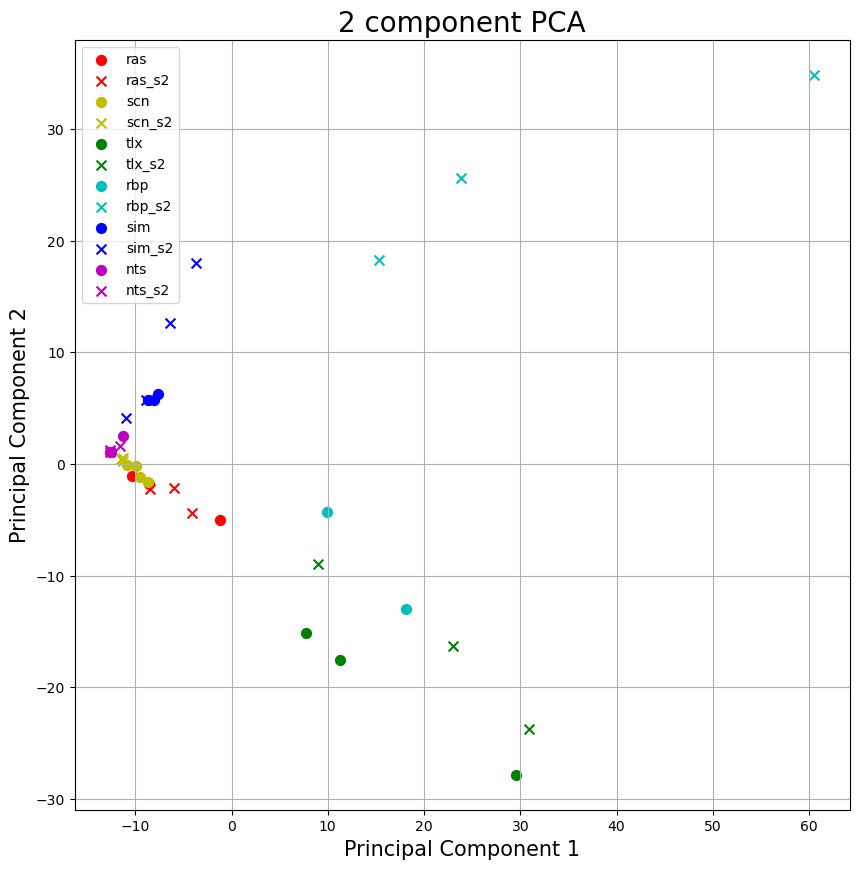

In [80]:
# based on most detailed level of anatomical region

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


for key, value in label_colors.items():
    indicesToKeep = principalDf['genotype_injection'] == key
    
    if 's2' in key:
        marker= 'x'
    else:
        marker='o'
            
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = value
               , s = 50, 
              marker=marker)

ax.legend(label_colors.keys())
ax.grid()

In [81]:
pca.explained_variance_ratio_

array([0.29888246, 0.16026181])

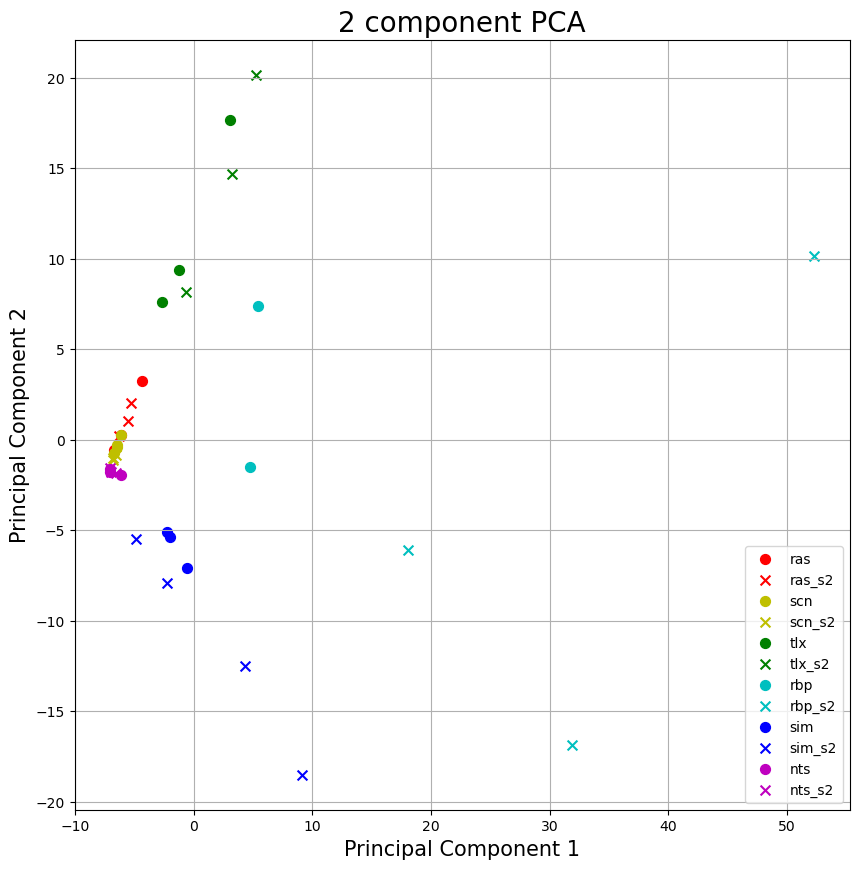

In [93]:

# based on parent level of anatomical region

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


for key, value in label_colors.items():
    indicesToKeep = principalDf['genotype_injection'] == key
    
    if 's2' in key:
        marker= 'x'
    else:
        marker='o'
            
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = value
               , s = 50, 
              marker=marker)

ax.legend(label_colors.keys())
ax.grid()

In [94]:
pca.explained_variance_ratio_

array([0.33571768, 0.15524933])

### tsne on categorical data

In [9]:
x = final_df.loc[:, features].values
# extract out all the values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [10]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=5, n_iter=1000)
z = tsne.fit_transform(x) 
# lower perplexity (ie.5) makes sense since our n_sample is quite low
# at n_iter= 1000, which is the default number, representation seemed stable



[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 37 samples in 0.001s...
[t-SNE] Computed neighbors for 37 samples in 0.447s...
[t-SNE] Computed conditional probabilities for sample 37 / 37
[t-SNE] Mean sigma: 4.098975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.244392
[t-SNE] KL divergence after 1000 iterations: 0.354724


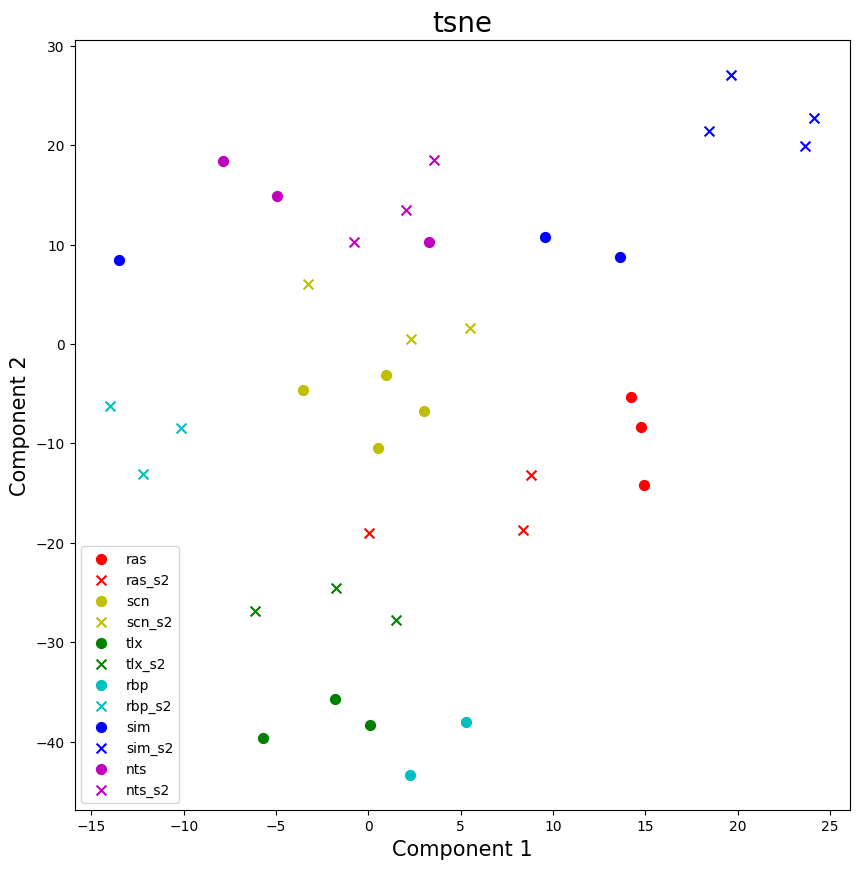

In [11]:
plot_lowD(z, reduce_type='tsne')

### umap on categorical data


In [9]:
import umap


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\umap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:

x = final_df.loc[:, features].values
# extract out all the values
x = StandardScaler().fit_transform(x)
# Standardizing the features

reducer = umap.UMAP(n_neighbors=3, random_state=1, min_dist=0.1, verbose=1)
# create instance

embedding = reducer.fit_transform(x)


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\umap\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_neighbors=3, random_state=1, verbose=1)
Fri Nov  3 15:19:26 2023 Construct fuzzy simplicial set
Fri Nov  3 15:19:27 2023 Finding Nearest Neighbors
Fri Nov  3 15:19:29 2023 Finished Nearest Neighbor Search
Fri Nov  3 15:19:33 2023 Construct embedding


Epochs completed: 100%| ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 500/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Nov  3 15:19:34 2023 Finished embedding


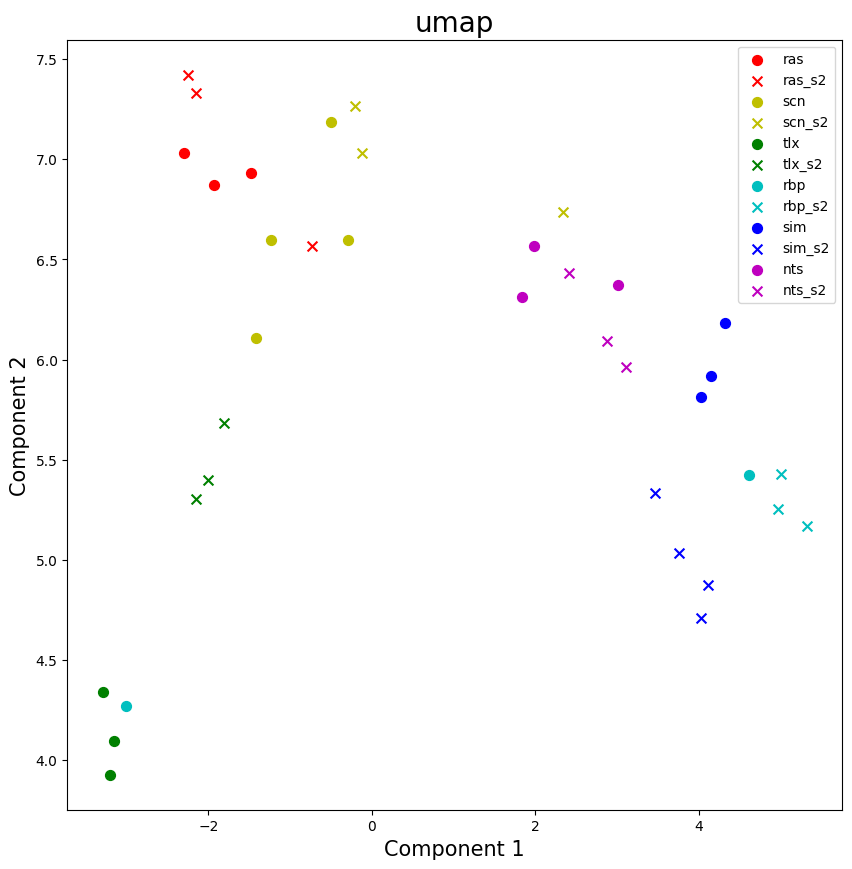

In [11]:
plot_lowD(embedding, reduce_type='umap')

## 3D spatial information (npy stacks) for all samples

In [4]:
final_column_order= ['AL254', 'AL255', 'AL257','AL303_s2', 'AL332_s2', 'AL333_s2','AL290', 'AL291', 'AL292', 'AL293','AL290_s2', 'AL292_s2', 'AL323_s2',
                'AL213','AL313', 'AL314','AL278_s2', 'AL280_s2', 'AL319_s2','AL211', 'AL318','AL288_s2', 'AL326_s2', 'AL327_s2',
                'AL207', 'AL209', 'AL273','AL281_s2', 'AL286_s2', 'AL321_s2','AL322_s2','AL274', 'AL285', 'AL311','AL274_s2', 'AL310_s2', 'AL330_s2' ]
# for ordering of sample so that s1 and s2 samples are together, and genotypes are ranged as ras, scn, tlx, rbp, sim and nts

In [5]:
# prepare label list for plotting

label_list= []

for i in final_column_order:
    if 's2' in i:
        sample_dictionary= {'sim': ['AL281','AL286','AL321','AL322'],
                        'rbp': ['AL288','AL326','AL327'],
                        'tlx': ['AL278','AL280','AL319'],
                        'ras': ['AL303','AL332','AL333'],
                        'scn': ['AL290','AL292','AL323'],
                        'nts': ['AL274','AL310','AL330']
                       }
        
        for key, value in sample_dictionary.items():
            if find_mousename(i) in value:
                label_list.append(key+'_s2')
        
        
    else: 
        sample_dictionary= {'sim': ['AL207','AL209','AL273'],
                        'rbp': ['AL211','AL318'],
                        'tlx': ['AL213','AL313','AL314'],
                        'ras': ['AL254','AL255','AL257'],
                        'scn': ['AL290','AL291','AL292','AL293'],
                        'nts': ['AL274','AL285','AL311']
                       }
        
        for key, value in sample_dictionary.items():
            if i in value:
                label_list.append(key)

label_list_series=pd.Series(label_list)


label_colors = {
    'ras': 'r', 'ras_s2': 'r',
    'scn': 'y', 'scn_s2': 'y',
    'tlx': 'g', 'tlx_s2': 'g',
    'rbp': 'c', 'rbp_s2': 'c',
    'sim': 'b', 'sim_s2': 'b',
    'nts': 'm', 'nts_s2': 'm'
}

In [6]:
# load the atlas (npy)

atlas= axons=np.load(r'D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\annotation_25.npy')


atlas_h=np.moveaxis(atlas, 1, 0)
print('Converted to horizontal atlas with shape', atlas_h.shape)
# reslice corontal atlas to horizontal atlas that is consistent with our sample's orientation


atlas_flat= atlas_h.flatten()
atlas_flat_mask = np.argwhere(atlas_flat>1)
# flatten annotation as an 1d array
# find indices of this 1d array that is not zero

Converted to horizontal atlas with shape (320, 528, 456)


In [7]:
# paths for s1 samples
site='s1'

indir= f'D:\\viral_results\\{site}\\npy'

files= os.listdir(indir)

# paths for s2 samples
site='s2'

indir2= f'D:\\viral_results\\{site}\\npy'

files2= os.listdir(indir2)

In [8]:
# initialize bunch of things

n_files= len(files)+len(files2)

axons_array= np.empty([len(atlas_flat_mask), n_files])
# create empty array of shape ( 32380454, # of samples from both s1 and s2) to store the gaussian filtered, masked and flatted axons 

sample_name=[]
# initialize list to store sample name

In [9]:
sigma=8
# sigma for gaussian filter
# radius is truncate(default,4) * sigma, hence a sigma=4 has a radius of 16 pixel which is 400 um
# keep this consistent as sigma=4 is used for quantifying MO axon centroids?? consider increase to get more spatial correlations?? 

# 4 is appearantly not giving enough similarities for tsne or umap to give sensible projections

for count, i in (enumerate(tqdm(files))): 
    
    file_path=os.path.join(indir,i)
    this_sample= find_mousename(i)
    # find the sample name
    
    sample_name.append(this_sample)
    
    axons=np.load(file_path)
    axons[0,0,0]=0
    axons[0,1,0]=0
    # load npy file and revert these two indices back to 0
    
    axons_filtered=gaussian_filter(axons, sigma=sigma)
    # apply 3d gaussian filter to axon
    
    axons_flat= axons_filtered.flatten()
    axons_flat_masked= axons_flat[atlas_flat_mask]
    # only take axons at indices that was non-zero in the atlas
    
    axons_array[:, count]= axons_flat_masked.T
    # transpose flatted axons and assign into numpy array

# repeat for s2 samples
for count, i in (enumerate(tqdm(files2))): 
    
    file_path=os.path.join(indir2,i)
    this_sample= find_mousename(i)
    # find the sample name
    
    sample_name.append(this_sample+'_s2')
    # add an _s2 indicator, for later ordering of samples
    
    axons=np.load(file_path)
    axons[0,0,0]=0
    axons[0,1,0]=0
    # load npy file and revert these two indices back to 0
    
    axons_filtered=gaussian_filter(axons, sigma=sigma)
    # apply 3d gaussian filter to axon
    
    axons_flat= axons_filtered.flatten()
    axons_flat_masked= axons_flat[atlas_flat_mask]
    # only take axons at indices that was non-zero in the atlas
    
    axons_array[:, len(files)+count]= axons_flat_masked.T
    # transpose flatted axons and assign into numpy array after the s1 samples
    
# each column= 1 sample, each row= 1 axon in each position


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [03:32<00:00, 11.20s/it]


In [10]:
# Standardizing the features
x = StandardScaler().fit_transform(axons_array.T)

# takes very long
# still not sure if necessary?

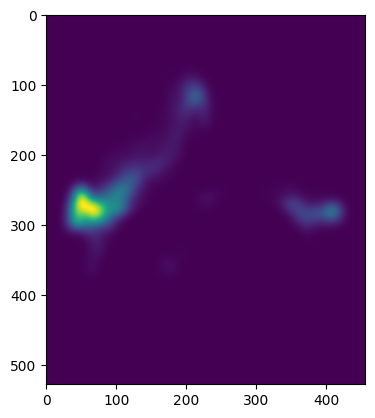

In [35]:
# check what does different gaussian filter sigma does and which value is sufficient

axons_filtered=gaussian_filter(axons, sigma=8)
plt.imshow(axons_filtered[100,:,:])

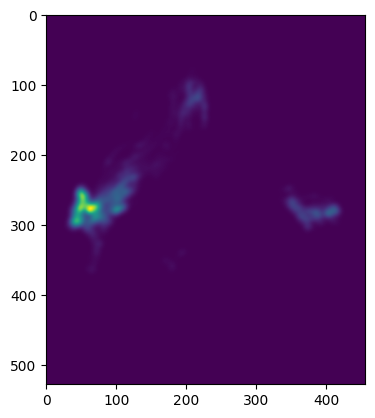

In [30]:
axons_filtered=gaussian_filter(axons, sigma=4)
plt.imshow(axons_filtered[100,:,:])

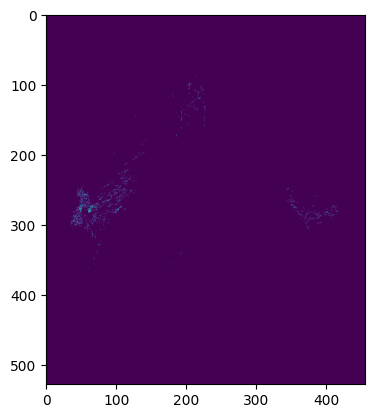

In [33]:

plt.imshow(axons[100,:,:])

### Spatial location - correlations

In [ ]:
# Correlation

b = np.corrcoef(axons_array.T)
# calculate correlation between each sample
correlation_3d=pd.DataFrame(data=b, index=sample_name, columns=sample_name)

In [ ]:
# re-order the data frame so that s1 and s2 samples are together and genotype orders are ras, scn, tlx, sim, rbp and nts

test=correlation_3d[final_column_order] 

test=test.T

ordered_corr=test[final_column_order]

ordered_corr.head()

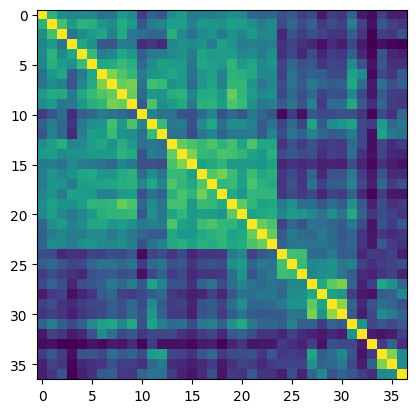

In [10]:
plt.imshow(ordered_corr.values)
plt.show()

In [11]:
ordered_corr.to_csv(r'D:\viral_results\s1_s2\correlation_3d_sigma4.csv')
# save as csv files to be plotted using plotting_sns.ipynb

### pca on the spatial axons (ie. many features, 37 samples)

In [17]:
axons_array.T.shape

# such that each row is a sample with many many columns as features

(37, 32380454)

In [18]:
# Standardizing the features
x = StandardScaler().fit_transform(axons_array.T)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf['sample']=final_column_order
# reassign the sample names back

principalDf['genotype_injection']=label_list_series
# find and assign genotype and injection site

# this step took a good few minutes to run

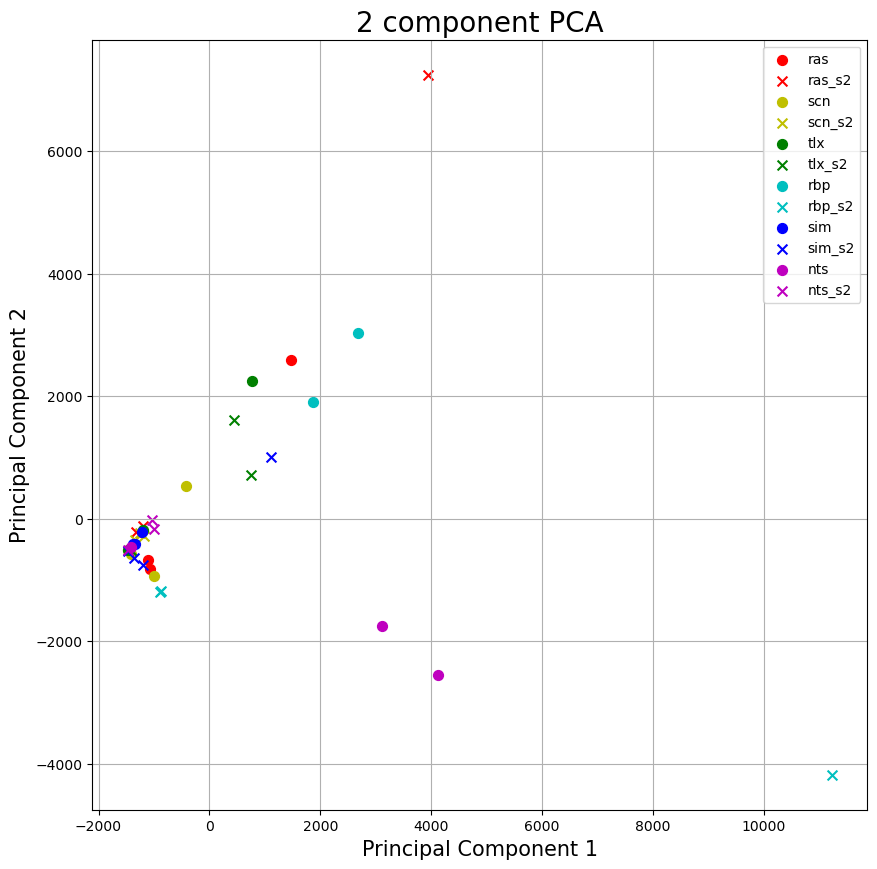

In [25]:
# based on most detailed level of anatomical region

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


for key, value in label_colors.items():
    indicesToKeep = principalDf['genotype_injection'] == key
    
    if 's2' in key:
        marker= 'x'
    else:
        marker='o'
            
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = value
               , s = 50, 
              marker=marker)

ax.legend(label_colors.keys())
ax.grid()

In [26]:
pca.explained_variance_ratio_

array([0.23181591, 0.1213501 ])

### try tsne on the spatial data set

unfortunately gaussian filter sigma=4 maybe not good. 
not enough similarities i guess to give sensible clusters

In [14]:
# do a pca first down to 37 features (this number is limited by min(nsamples, nfeatures), in our case is the number of sample- 37) or so

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(x)
# try to reduce to the first 10 component 

In [15]:
pca.explained_variance_ratio_[0:10].sum()
# ie. first 10 component explains 81% of variance

0.8566319618160075

In [16]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=5, n_iter=1000)

z = tsne.fit_transform(principalComponents) 

# did not make sense when running on full normalized data, or the first 10 pc of normalized data (account for 80% of variance??)


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 37 samples in 0.011s...
[t-SNE] Computed neighbors for 37 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 37 / 37
[t-SNE] Mean sigma: 314.309131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.996788
[t-SNE] KL divergence after 1000 iterations: 0.141640


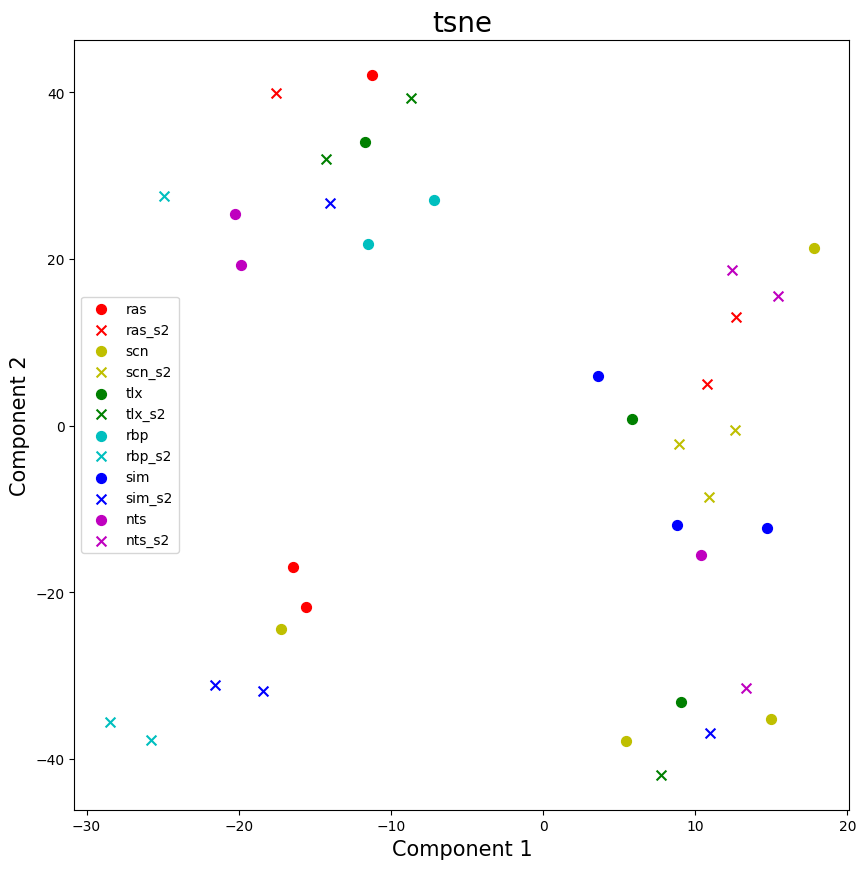

In [17]:
plot_lowD(z,'tsne')

### try umap on the spatial data set

unfortunately gaussian filter sigma=4 maybe not good. 
not enough similarities i guess to give sensible clusters


In [36]:
umap.UMAP?

Init signature:
umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold

In [31]:
import umap


C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\umap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:

reducer = umap.UMAP(n_neighbors=3, random_state=1, min_dist=0.1, verbose=1)
# create instance

embedding = reducer.fit_transform(principalComponents)

C:\Users\liu\AppData\Local\Continuum\anaconda3\envs\umap\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_neighbors=3, random_state=1, verbose=1)
Fri Nov  3 16:20:31 2023 Construct fuzzy simplicial set
Fri Nov  3 16:20:31 2023 Finding Nearest Neighbors
Fri Nov  3 16:20:31 2023 Finished Nearest Neighbor Search
Fri Nov  3 16:20:31 2023 Construct embedding


Epochs completed: 100%| ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 500/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Nov  3 16:20:32 2023 Finished embedding


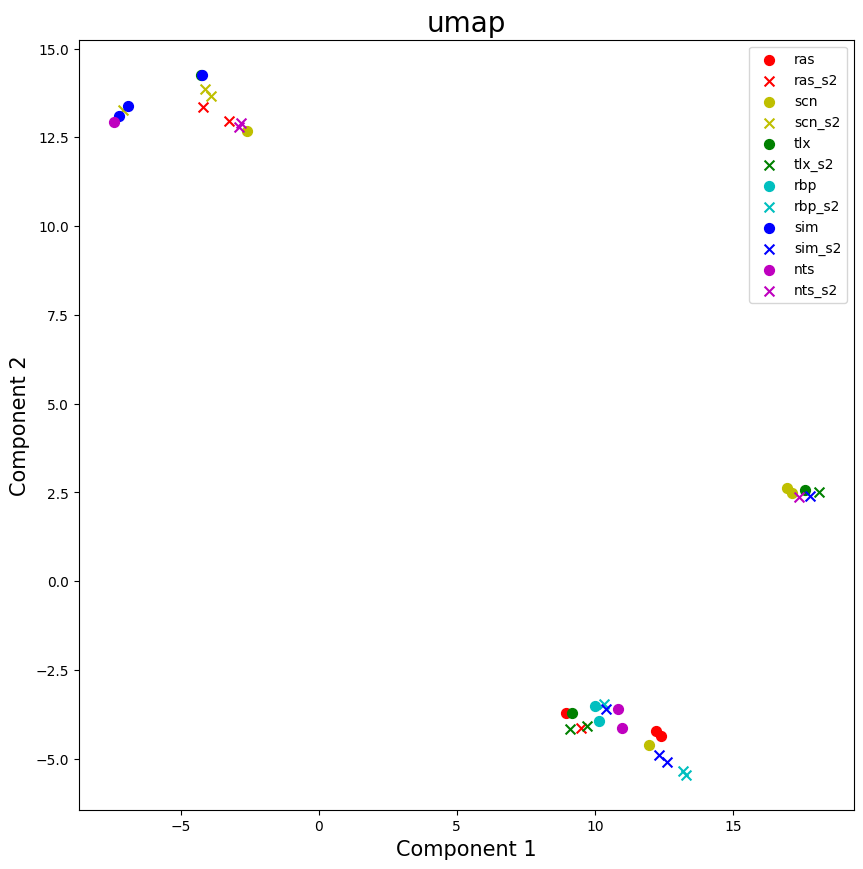

In [43]:
plot_lowD(embedding, reduce_type='umap')